#### **Libraries needed**

In [26]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torch.utils.data import random_split

from torchvision import models, transforms

from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from collections import Counter

import time
import copy
import seaborn as sns
import random
import cv2
import numpy as np

Some technicalites:


In [2]:
%matplotlib inline

plt.ion()

In [3]:
seed = 42
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### **Data processing**

We apply the same transformation to all the images

In [5]:
weights = models.MobileNet_V2_Weights.DEFAULT
preprocess = weights.transforms()

We load now the images and divide it into training, validation, test and visualization groups.

In [6]:
train_percent = 0.8

gtsrb_path = "/content"

all_images_train = torchvision.datasets.GTSRB(root=gtsrb_path, split='train', download=True, transform=preprocess)

#We decided to use only a 1/4 of the original train and validation data

one_fourth = list(range(0, len(all_images_train), 4))

partial_dataset_train = torch.utils.data.Subset(all_images_train, one_fourth)

train_size = int(train_percent * len(partial_dataset_train))

val_size = int((len(partial_dataset_train) - train_size))

We obtain the final sets of images and labels. We repeat the process with the visualization and test sets.

In [7]:
train_set, val_set = random_split(partial_dataset_train,[train_size, val_size])

In [8]:
all_images_test = torchvision.datasets.GTSRB(root=gtsrb_path, split='test', download=True, transform=preprocess)

test_percent = 0.9

partial_dataset_test = torch.utils.data.Subset(all_images_test, one_fourth)

test_set_size = int(len(all_images_test)* test_percent)

test_vis_size= int(len(all_images_test) - test_set_size)

In [9]:
test_set, test_vis_set = random_split(all_images_test,[test_set_size,test_vis_size], )

In [10]:
#Let's visualize the dataset we are using

train_loader = DataLoader(train_set, batch_size=64, shuffle=False)

# Initialize a counter to keep track of class labels
class_counts = Counter()

# Iterate through the subset
for images, labels in train_loader:
    class_counts.update(labels.numpy())  # Update the counter with the labels of this batch

# Convert the counter to a sorted list
sorted_class_counts = sorted(class_counts.items())

# Unzip the sorted counts
classes, counts = zip(*sorted_class_counts)

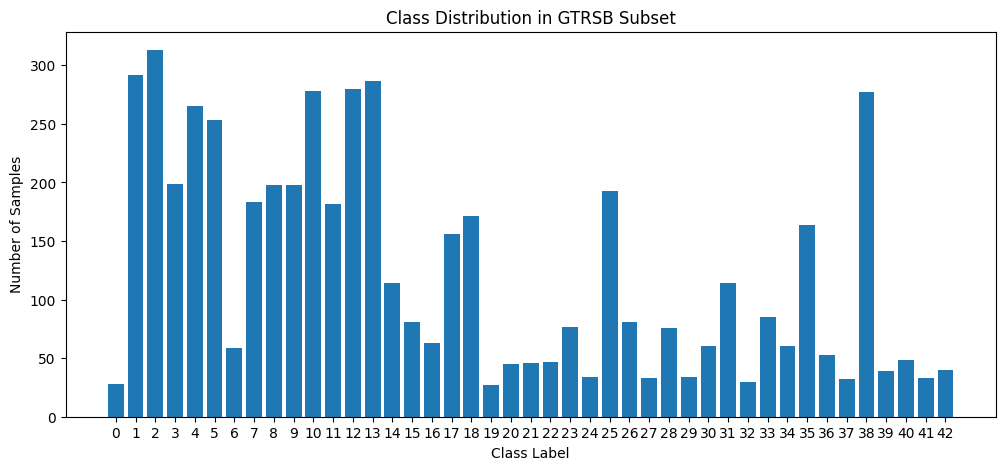

In [11]:
# Plot the class distribution
plt.figure(figsize=(12, 5))
plt.bar(classes, counts)
plt.xlabel('Class Label')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in GTRSB Subset')
plt.xticks(classes)  # Show class labels on x-axis
plt.show()

In [10]:
training_path = f"{gtsrb_path}/gtsrb/GTSRB/Training"

In [11]:
#Here we associate each index of the labels with the corresponding class
class_names = [
    "Speed limit 20km/h",        # 0
    "Speed limit 30km/h",        # 1
    "Speed limit 50km/h",        # 2
    "Speed limit 60km/h",        # 3
    "Speed limit 70km/h",        # 4
    "Speed limit 80km/h",        # 5
    "End of speed limit 80km/h", # 6
    "Speed limit 100km/h",       # 7
    "Speed limit 120km/h",       # 8
    "No passing",                # 9
    "No passing for vehicles > 3.5t",  # 10
    "Right-of-way at intersection",    # 11
    "Priority road",             # 12
    "Yield",                     # 13
    "Stop",                      # 14
    "No vehicles",               # 15
    "Vehicles > 3.5t prohibited",      # 16
    "No entry",                  # 17
    "General caution",           # 18
    "Curve left",                # 19
    "Curve right",               # 20
    "Double curve",              # 21
    "Bumpy road",                # 22
    "Slippery road",             # 23
    "Road narrows right",        # 24
    "Road work",                 # 25
    "Traffic signals",           # 26
    "Pedestrians",               # 27
    "Children crossing",         # 28
    "Bicycles crossing",         # 29
    "Ice/snow warning",          # 30
    "Wild animals crossing",     # 31
    "End of speed & passing limits",  # 32
    "Turn right ahead",          # 33
    "Turn left ahead",           # 34
    "Ahead only",                # 35
    "Go straight or right",      # 36
    "Go straight or left",       # 37
    "Keep right",                # 38
    "Keep left",                 # 39
    "Roundabout",                # 40
    "End of no passing",         # 41
    "End of no passing > 3.5t"   # 42
]


In [14]:
#Lets visualize the images we are working with
def imshow(images, labels):
  plt.figure(figsize=(15,15))
  for i in range(len(images)):
    plt.subplot(16,8,i+1)
    plt.imshow(images[i].permute(1,2,0)) # (3, 32, 32) -> (32, 32, 3)
    plt.title(labels[i].item())
    plt.axis("off")
  plt.show()

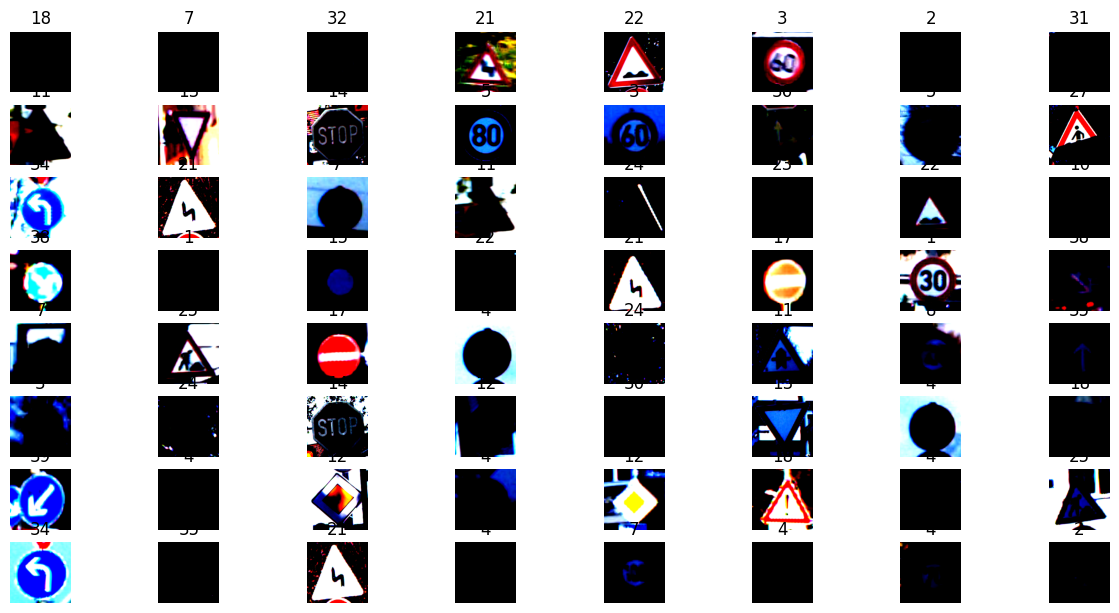

In [15]:
test_vis_data_loader = DataLoader(test_vis_set, batch_size=64, shuffle=False)

images, labels = next(iter(test_vis_data_loader)) # get a pack (64) of images
imshow(images, labels)

### **Setting up our model**



In [12]:
# Here we fix the hyperparameters that we will be using
bs = 128  # batch size
lr = 0.1  # learning rate
epochs = 10  # number of epochs
momentum = 0.9
step_size = 7
gamma = 0.1

Here we specify the structure of our model

In [17]:
model = torchvision.models.mobilenet_v2(pretrained=True)

in_feature_number = model.classifier[1].in_features

model.classifier = nn.Sequential(   # setting the top layers of the classifier to custom
    nn.Linear(in_feature_number, 512),
    nn.BatchNorm1d(512), # eps=1e-05, momentum=0.1,
    nn.ReLU(),
    nn.Linear(512, 43)
)

# We initialize the new added layers with the seed so we can reproduce the
# experiments.
for layer in model.classifier :
    if isinstance(layer, nn.Linear):  # Check if the layer is a Linear layer
        init.kaiming_uniform_(layer.weight, nonlinearity='relu')  # Xavier initialization
        if layer.bias is not None:
            init.zeros_(layer.bias)  # Initialize biases to zeros


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 98.1MB/s]


#### **Some useful functions:**


Visualizing the loss and accuracy for validation and training


In [13]:
def visualize_metrics(train_acc, val_acc, train_loss, val_loss):
    plt.figure(figsize=(10,10))

    plt.subplot(2,2,1)
    plt.plot(train_acc)
    plt.title("Training accuracy")

    plt.subplot(2,2,2)
    plt.plot(val_acc)
    plt.title("Validation accuracy")

    plt.subplot(2,2,3)
    plt.plot(train_loss)
    plt.title("Training loss")

    plt.subplot(2,2,4)
    plt.plot(val_loss)
    plt.title("Validation loss")

    plt.show()

Setting up the visualizing method

In [14]:
def visualize_metrics(train_acc, val_acc, train_loss, val_loss):
# Create a figure with subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

    # Plot loss
    ax1.plot(train_loss, label='Training Loss', color='blue', marker='o')
    ax1.plot(val_loss, label='Validation Loss', color='orange', marker='o')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid()

    # Plot accuracy
    ax2.plot(train_acc, label='Training Accuracy', color='green', marker='o')
    ax2.plot(val_acc, label='Validation Accuracy', color='red', marker='o')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid()

    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()

Method to make predictions over a set of images

In [23]:
def evaluate_model(model, test_set, batch_size):
    was_training = model.training
    model.eval()

    model = model.to(device)

    all_preds = []
    all_labels = []

    test_data_loader = DataLoader(test_set, batch_size = batch_size, shuffle = False)

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        model.train(mode=was_training)

    conf_matrix = confusion_matrix(all_labels, all_preds)
    conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    return conf_matrix_normalized

Method to show some predictions on unseen images

In [16]:
def show_predictions(model, vis_set, batch_size, num_of_images=6):
    was_training = model.training
    model.eval()
    model = model.to(device)
    images_so_far = 0
    fig = plt.figure(figsize=(12,12))

    vis_data_loader = DataLoader(vis_set, batch_size=batch_size, shuffle=False)

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(vis_data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            inp_size = inputs.size()[1]

            for j in range(inp_size):
                images_so_far += 1
                ax = plt.subplot(inp_size, num_of_images//inp_size, images_so_far)
                ax.axis('off')
                ax.set_title(f"pred: {class_names[preds[j]]}\ntrue: {class_names[labels[j]]}")

                resized_image = torchvision.transforms.ToTensor()(torchvision.transforms.Resize((1024, 1024))(torchvision.transforms.ToPILImage()(inputs.cpu().data[j])))

                ax.imshow(resized_image.permute(1,2,0))

                if images_so_far == num_of_images:
                    model.train(mode=was_training)
                    return

        model.train(mode=was_training)

Method to show gradients

In [17]:
def plot_gradient_histogram(model):
    all_grads = []
    for param in model.classifier.parameters():
        if param.grad is not None:
            all_grads.append(param.grad.view(-1))
    if all_grads != []:
      all_grads = torch.cat(all_grads).cpu().numpy()

      plt.hist(all_grads, bins=100, range=(-1, 1))  # Adjust range if necessary
      plt.xlabel("Gradient Value")
      plt.ylabel("Frequency")
      plt.title("Gradient Histogram")
      plt.show()

#### **Training function**

Function for training our model

In [18]:
def train_model(model, criterion, optimizer, lr_scheduler, train_set, val_set, num_epochs=25, batch_size=64):
    #We keep track of the time it takes to run this function
    since = time.time()

    #We utilise the GPU if its avaliable
    model = model.to(device)

    # We initialise the value we want to keep after execution
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    #Lists that contain the values after each epoch
    train_acc = []
    val_acc = []
    train_loss = []
    val_loss = []

    #We encapsulate our images and labels in a Dataloader

    train_data_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_data_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

    data_loader = { "train" : train_data_loader, "val" : val_data_loader }
    data_loader_len = { "train" : len(train_data_loader), "val" : len(val_data_loader) }
    print("DataLoaders set up succesfully")
    #We repeat this proccess for the number of epochs fixed
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print('-' * 20)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                lr_scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in data_loader[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history only if in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                curr_loss = loss.item() * inputs.size(0)
                curr_corrects = torch.sum(preds == labels.data)

                running_loss += curr_loss
                running_corrects += curr_corrects

            epoch_loss = running_loss / data_loader_len[phase]
            epoch_acc = running_corrects.double() / data_loader_len[phase]

            if phase == 'train':
                train_acc.append(float(epoch_acc))
                train_loss.append(float(epoch_loss))
            else:
                val_acc.append(float(epoch_acc))
                val_loss.append(float(epoch_loss))

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            plot_gradient_histogram(model)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    visualize_metrics(train_acc, val_acc, train_loss, val_loss)

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model

### **Transfer learning**

We prepare our model for transer learning.

In [34]:
# Freeze all layers (i.e., disable training)
for param in model.parameters():
    param.requires_grad = False

# Unfreeze final layer (named fc)
for param in model.classifier.parameters():
    param.requires_grad = True

# Put the model on the GPU
model = model.to(device)

# Loss function
criterion_loss = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizerSGD = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizerSGD, step_size= step_size, gamma= gamma)

Let's aplicate transfer learning

DataLoaders set up succesfully
Epoch 1/5
--------------------
train Loss: 106.5193 Acc: 27.5238


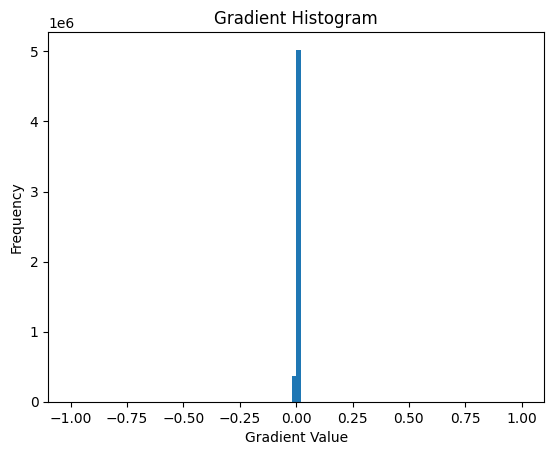

val Loss: 111.2905 Acc: 26.9048
Epoch 2/5
--------------------
train Loss: 85.3248 Acc: 33.3095


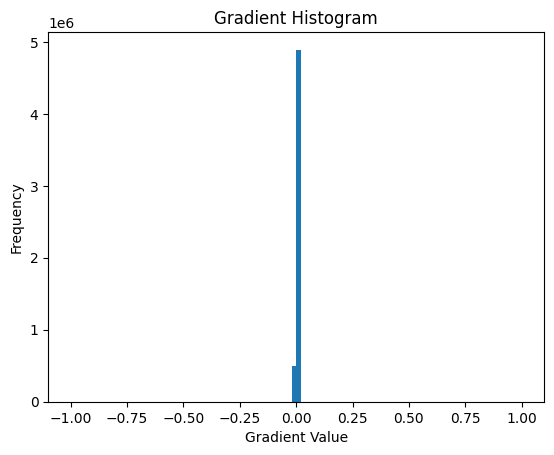

val Loss: 89.1842 Acc: 32.2381
Epoch 3/5
--------------------
train Loss: 76.5648 Acc: 35.1905


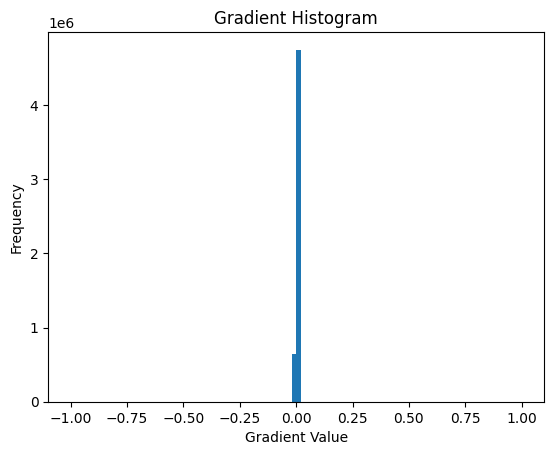

val Loss: 85.3527 Acc: 32.9524
Epoch 4/5
--------------------


KeyboardInterrupt: 

In [37]:
model = train_model(model, criterion_loss, optimizerSGD, exp_lr_scheduler, train_set, val_set, num_epochs=epochs, batch_size=bs)

Let's visuzalize the results with a confusion matrix over the test set.

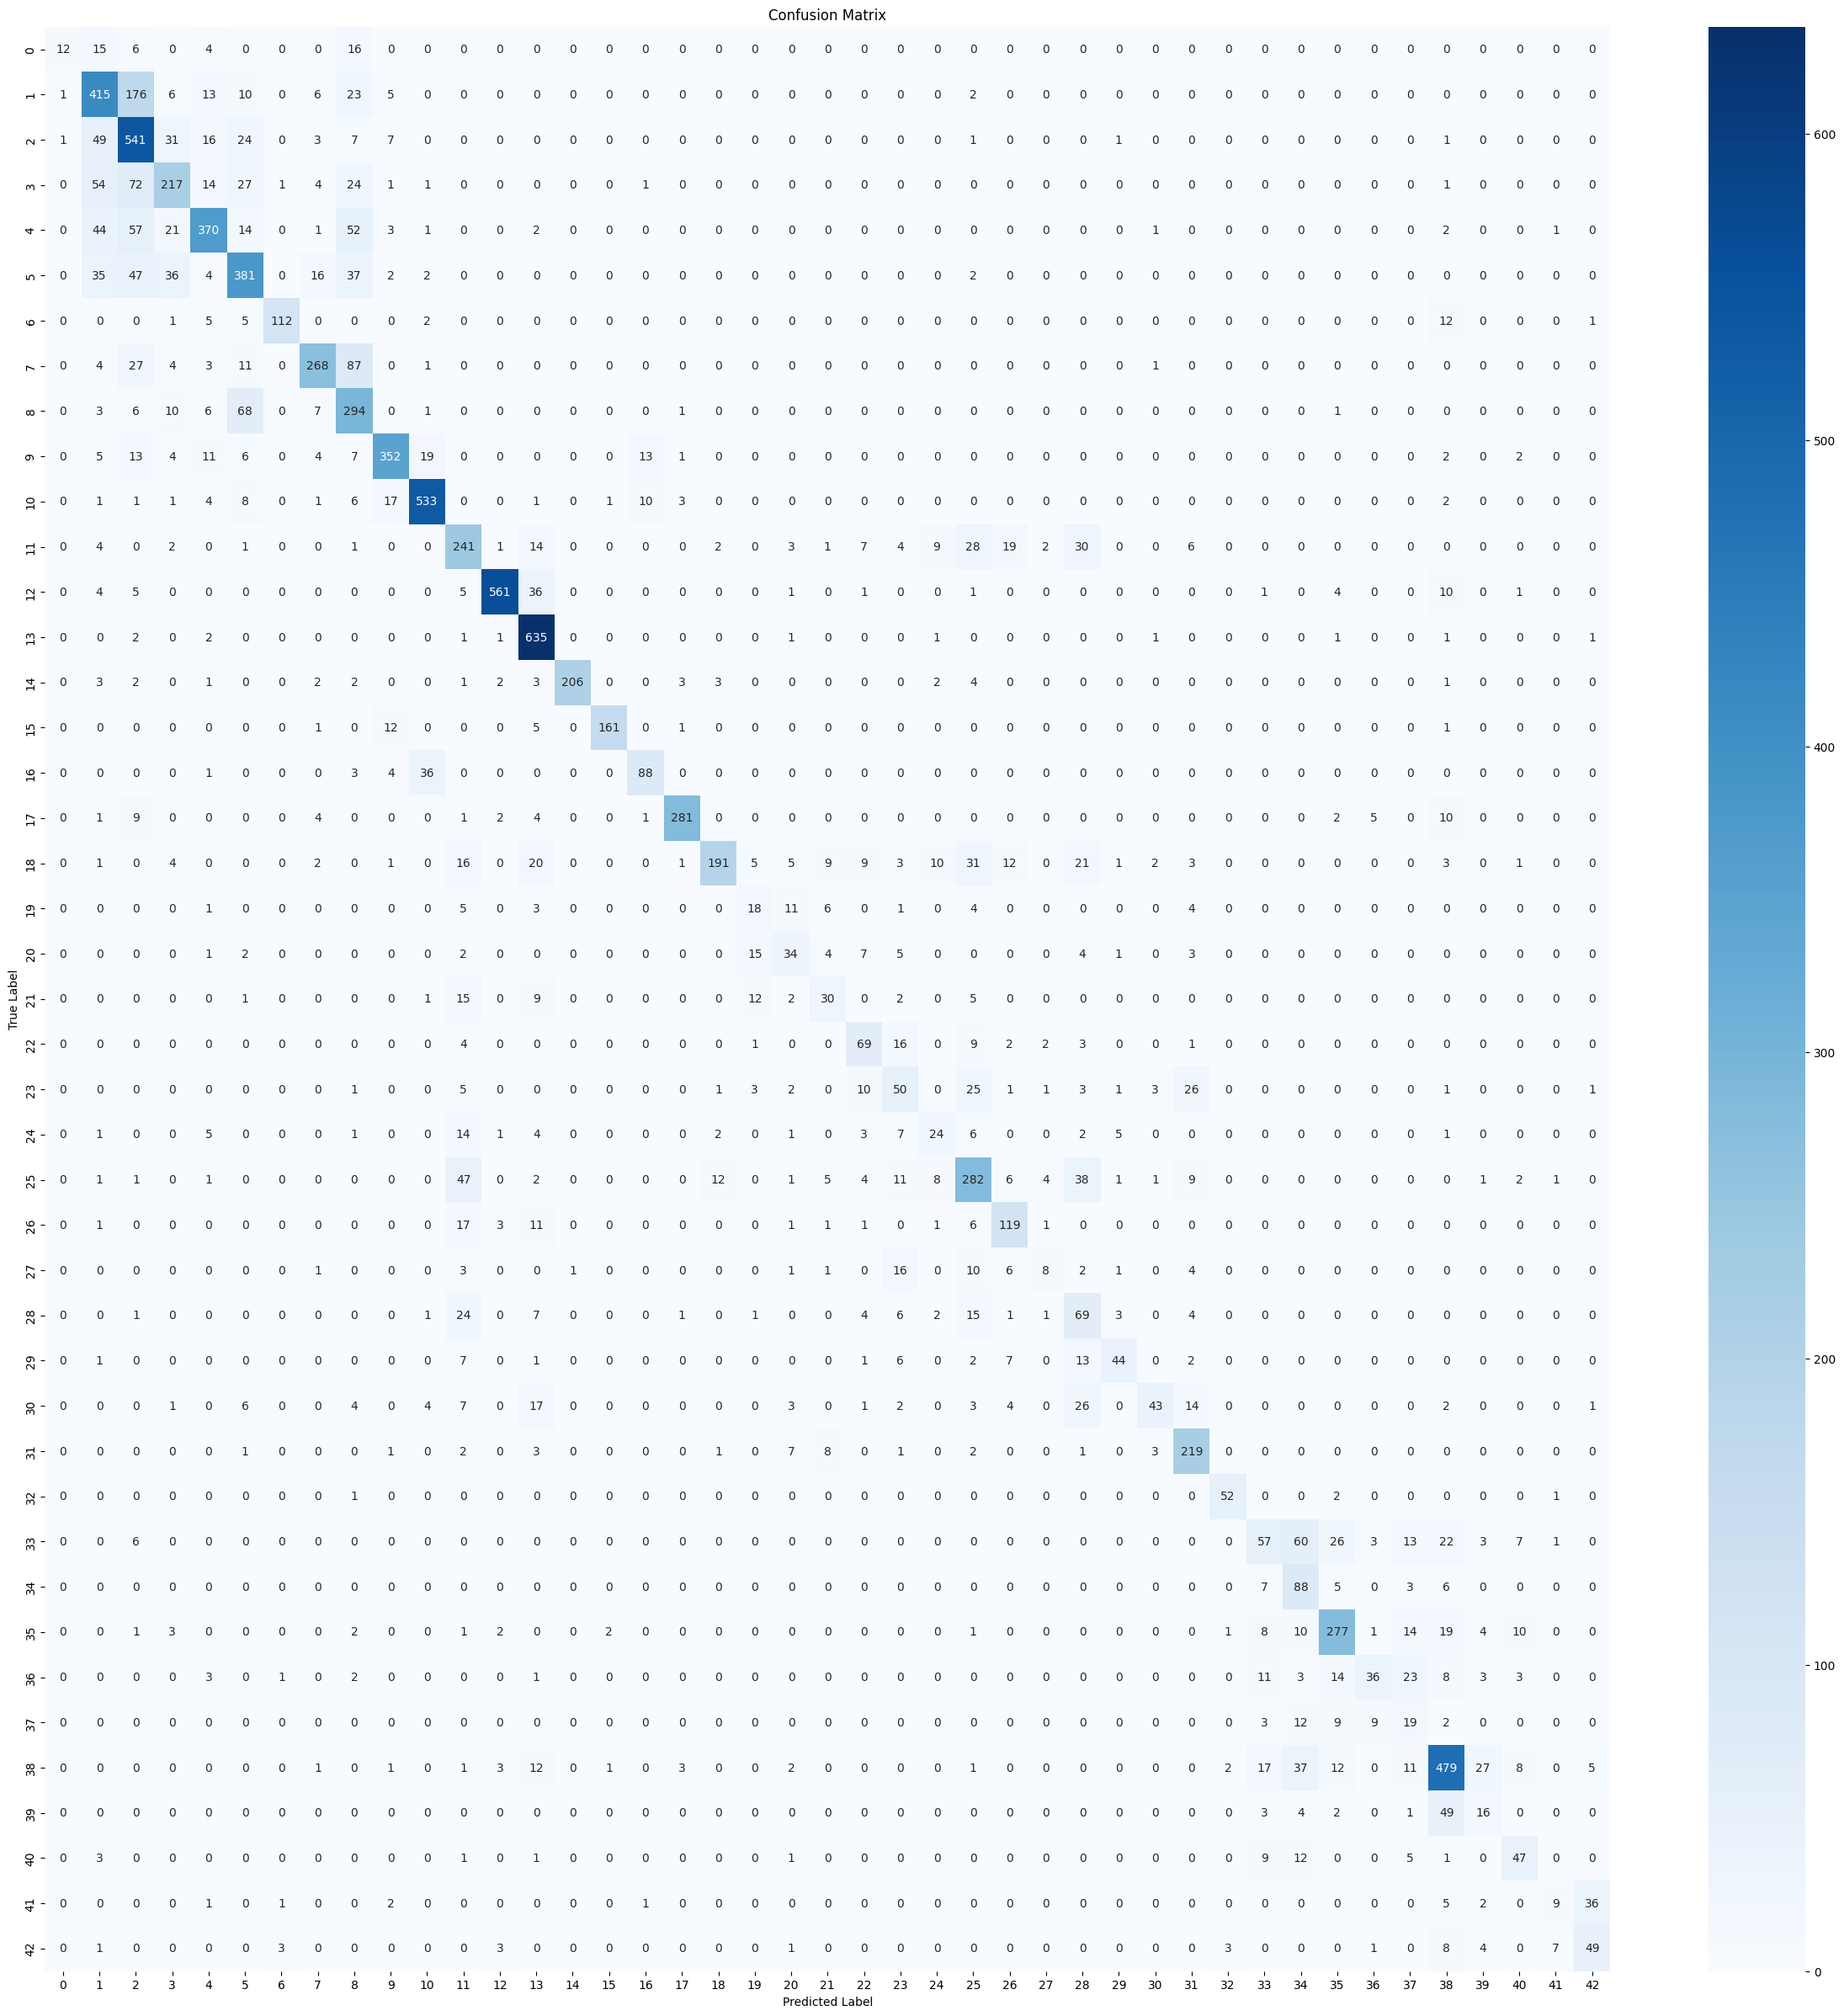

In [26]:
conf_matrix = evaluate_model(model, test_set, bs)

plt.figure(figsize=(30,30))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

Let's see a batch of the predictions and their true labels

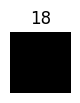

In [27]:
test_dataloader = DataLoader(test_vis_set)

imgs, labels = next(iter(test_dataloader))

imshow(imgs, labels)

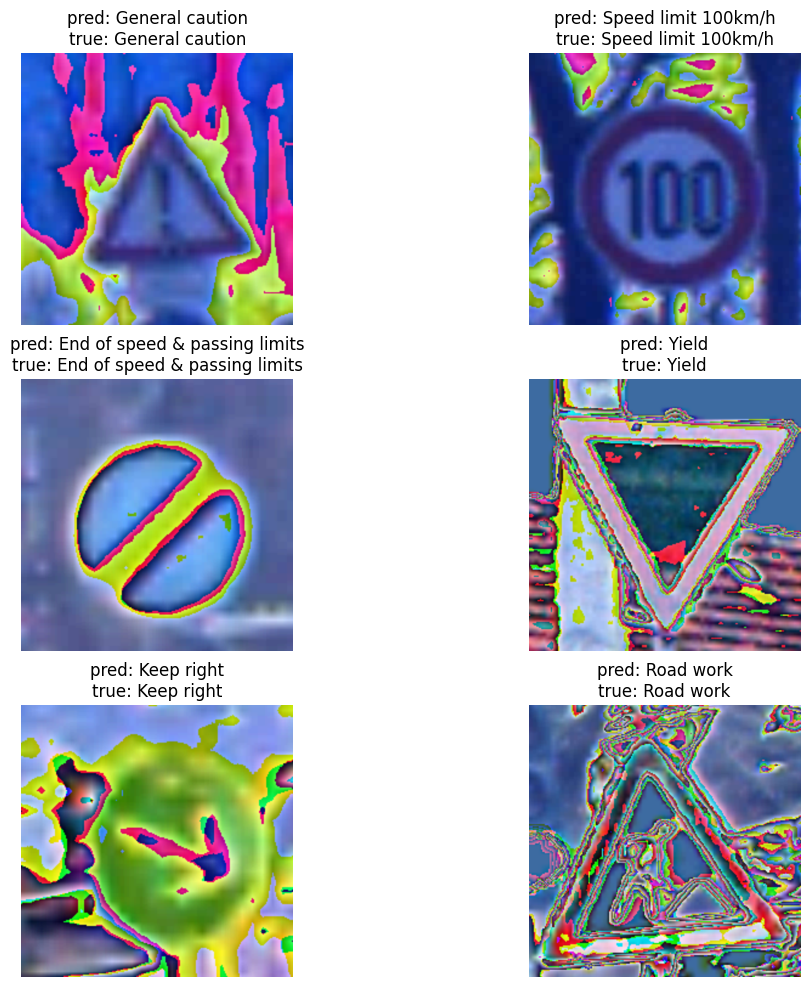

In [28]:
show_predictions(model, test_vis_set, bs) # 6 images are shown by default

### **Fine tuning**

We unfreeze the decoder

In [29]:
for param in model.parameters(): # unfreeze every trainable parameter
    param.requires_grad = True

Now we retrain the model for a few epochs

DataLoaders set up succesfully
Epoch 1/8
--------------------
train Loss: 290.2608 Acc: 5.0476


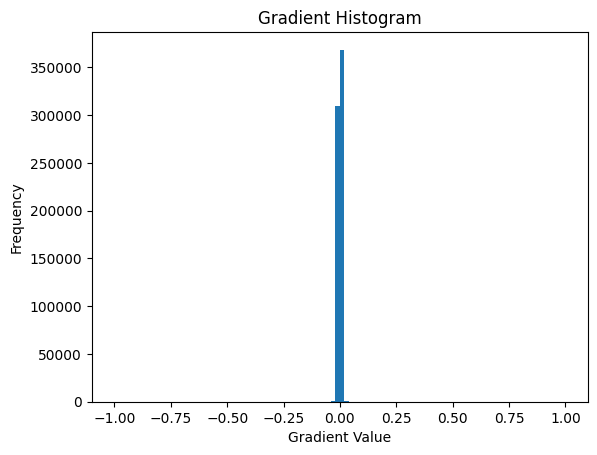

val Loss: 1290.3018 Acc: 1.8571
Epoch 2/8
--------------------
train Loss: 228.7256 Acc: 4.9881


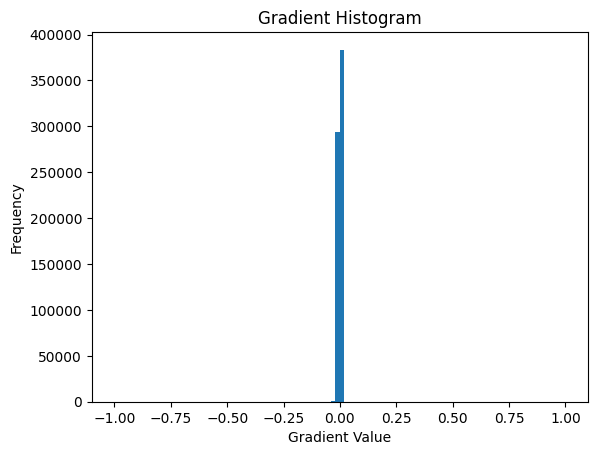

val Loss: 271.1560 Acc: 4.6667
Epoch 3/8
--------------------
train Loss: 220.6868 Acc: 5.2381


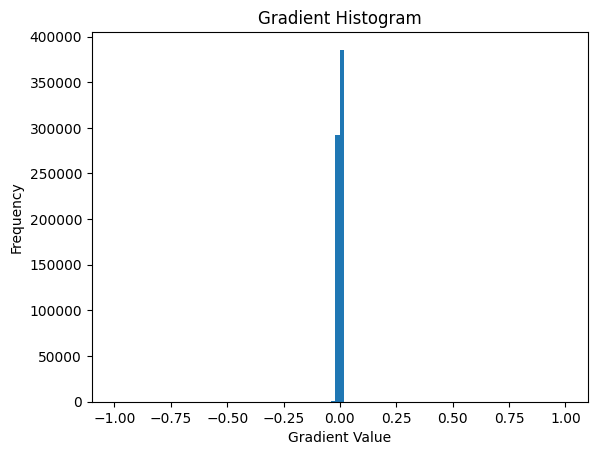

val Loss: 225.0364 Acc: 4.7619
Epoch 4/8
--------------------
train Loss: 214.1221 Acc: 6.2857


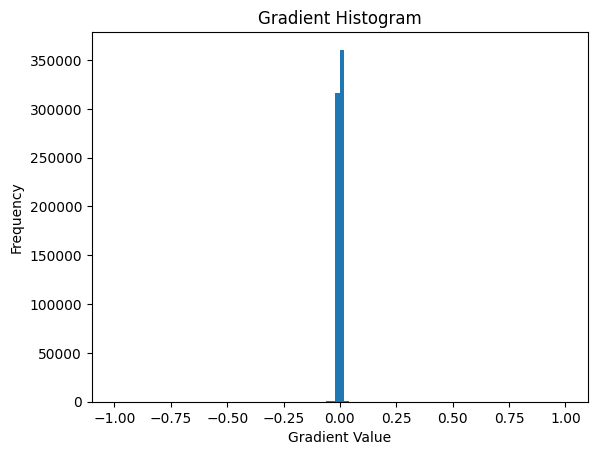

val Loss: 215.5599 Acc: 6.0952
Epoch 5/8
--------------------
train Loss: 208.2924 Acc: 7.1667


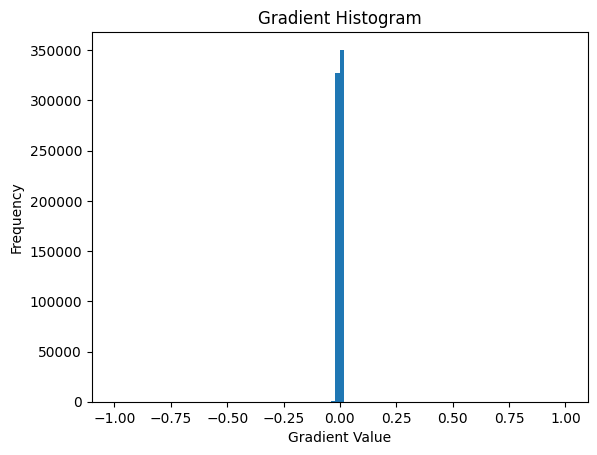

val Loss: 211.2389 Acc: 6.9048
Epoch 6/8
--------------------
train Loss: 196.9683 Acc: 9.0119


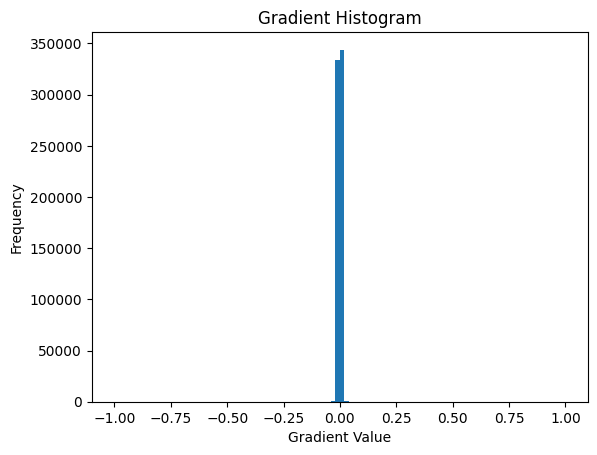

val Loss: 196.2891 Acc: 9.5238
Epoch 7/8
--------------------
train Loss: 179.3218 Acc: 12.1667


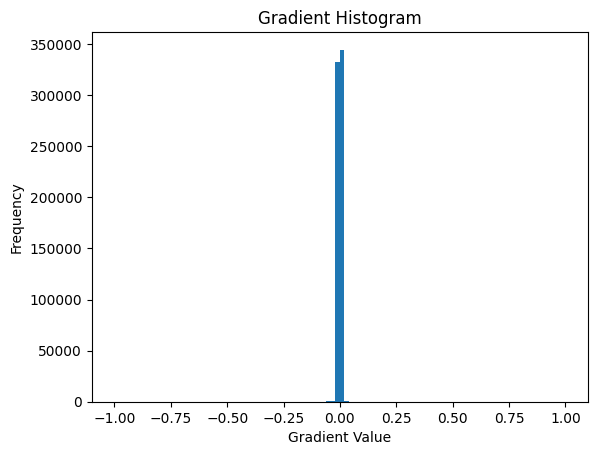

val Loss: 179.8841 Acc: 11.8571
Epoch 8/8
--------------------
train Loss: 161.3650 Acc: 16.0714


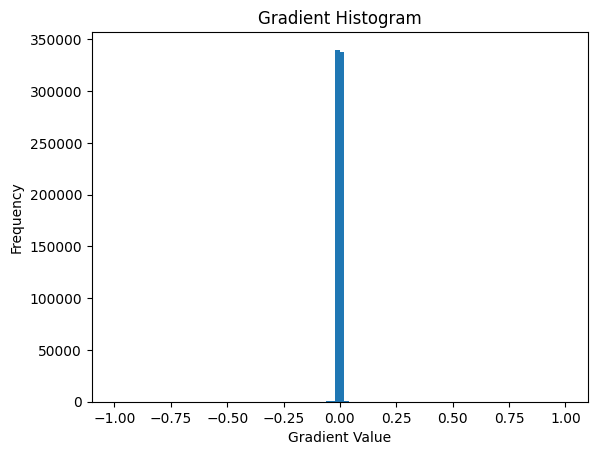

val Loss: 158.6720 Acc: 16.9524
Training complete in 5m 9s
Best val Acc: 16.952381


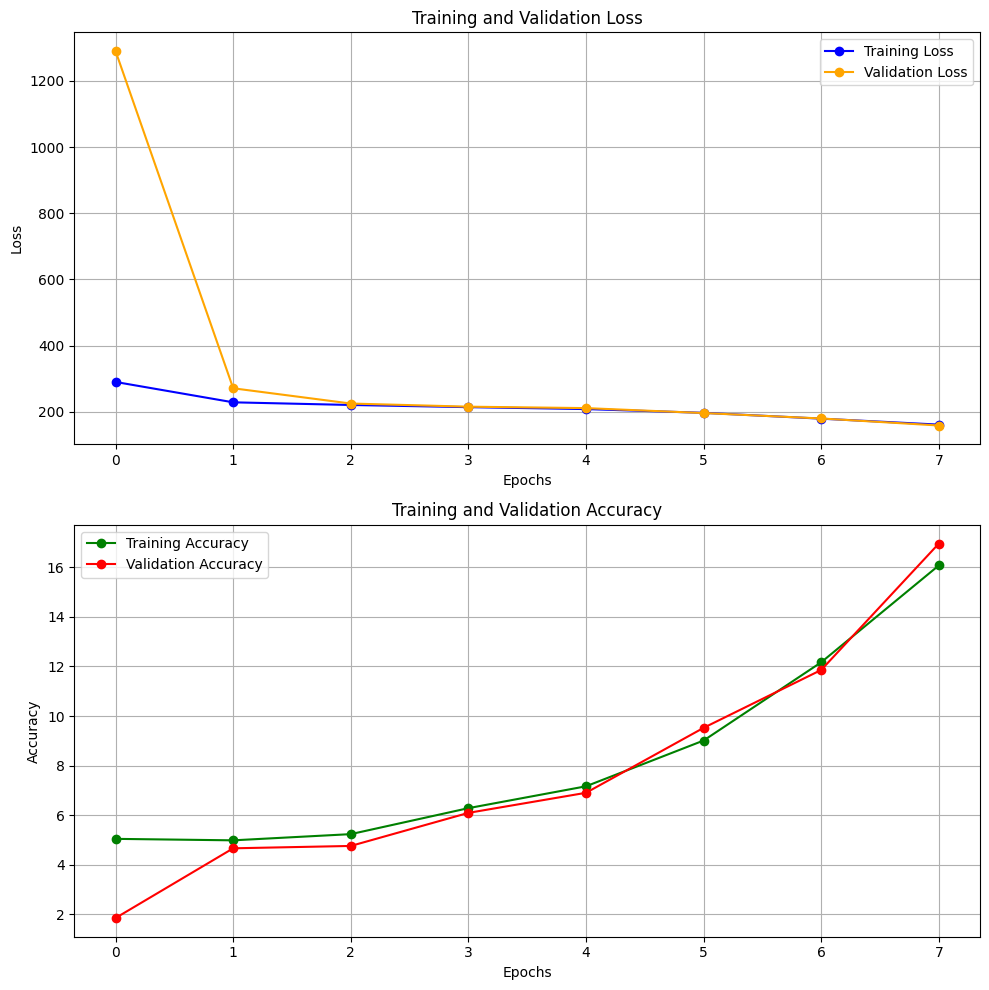

In [30]:
model = train_model(model, criterion_loss, optimizerSGD, exp_lr_scheduler, train_set, val_set, num_epochs=8)

And finally we visualize the results:


In [24]:
conf_matrix = evaluate_model(model, test_vis_set, bs)

plt.figure(figsize=(30,30))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

NameError: name 'np' is not defined

### **Experimenting with increasing the learning rate**

The motivation for experimenting with the learning rate comes from the fact that, because our gradients were vanishing, we decided to add a Batch Normalization layer. Therefore now we can try to use initialize our model with higher learning rates. We also want to achieve a better accuracy, therefore we
will try to use CLR and a deeper study of the reasonable noundary values that
are suitable for our model and dataset.

#### **Implementing the new architecture**

In [19]:
# Load the pre-trained MobileNetV2 model
# pretrained=True indicates we'll use weights pre-trained on ImageNet
model = torchvision.models.mobilenet_v2(pretrained=True)

# Get the number of input features for the classifier's fully connected layer
# This is needed to define the input size for our custom classifier
in_feature_number = model.classifier[1].in_features

model.classifier = nn.Sequential(
    nn.Linear(in_feature_number, 2048),  # First dense layer with 2048 units
    nn.ReLU(),                           # ReLU activation
    nn.Linear(2048, 1024),                # Second dense layer with 1024 units
    nn.ReLU(),                           # ReLU activation
    nn.Linear(1024, 512),                 # Third dense layer with 512 units
    nn.ReLU(),                           # ReLU activation
    nn.Linear(512, 256),                  # Fourth dense layer with 256 units
    nn.ReLU(),                           # ReLU activation
    nn.Linear(256, 43)                    # Final output layer with 43 classes (for GTSRB)
)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [20]:
# Freeze all layers (i.e., disable training)
for param in model.parameters():
    param.requires_grad = False

# Unfreeze final layer (named fc)
for param in model.classifier.parameters():
    param.requires_grad = True

# Put the model on the GPU
model = model.to(device)

# Loss function
criterion_loss = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizerSGD = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizerSGD, step_size= step_size, gamma= gamma)

DataLoaders set up succesfully
Epoch 1/10
--------------------


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


train Loss: 432.7354 Acc: 10.6667


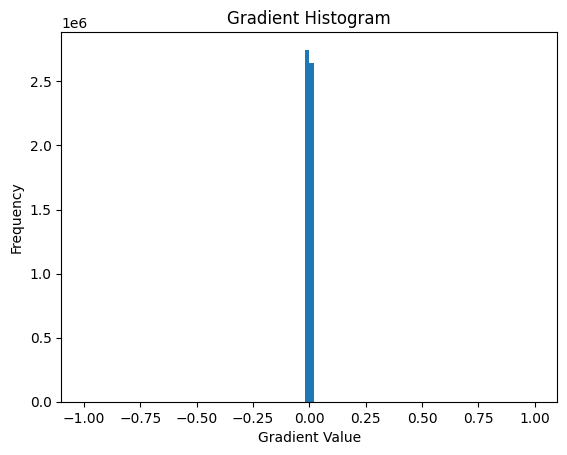

val Loss: 372.6912 Acc: 17.3636
Epoch 2/10
--------------------
train Loss: 316.3548 Acc: 29.1667


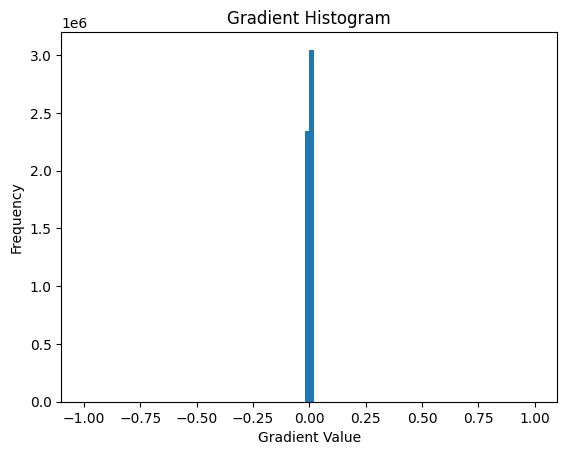

val Loss: 263.6881 Acc: 37.9091
Epoch 3/10
--------------------
train Loss: 257.9752 Acc: 41.2143


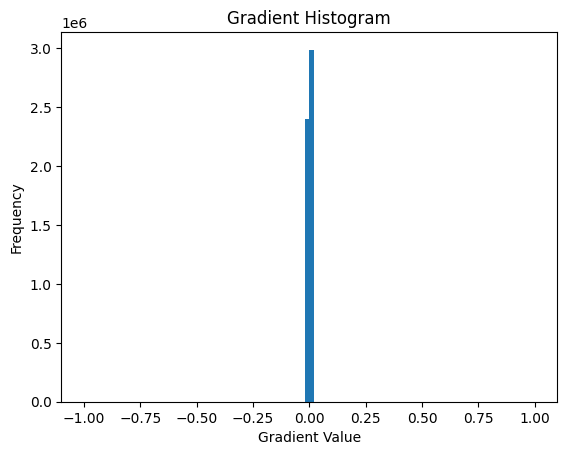

val Loss: 234.8935 Acc: 44.6364
Epoch 4/10
--------------------
train Loss: 214.9811 Acc: 54.0476


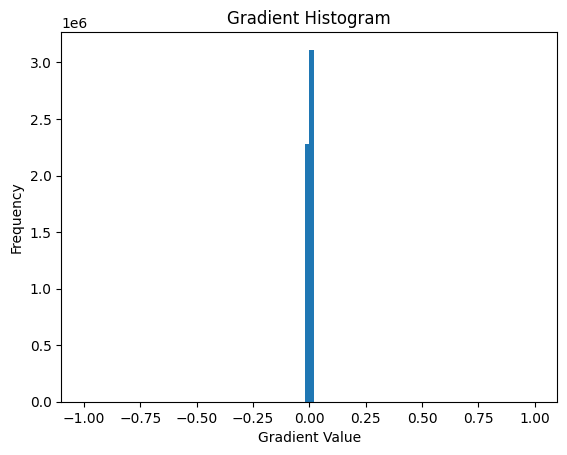

val Loss: 195.9287 Acc: 50.5455
Epoch 5/10
--------------------
train Loss: 199.7549 Acc: 59.0714


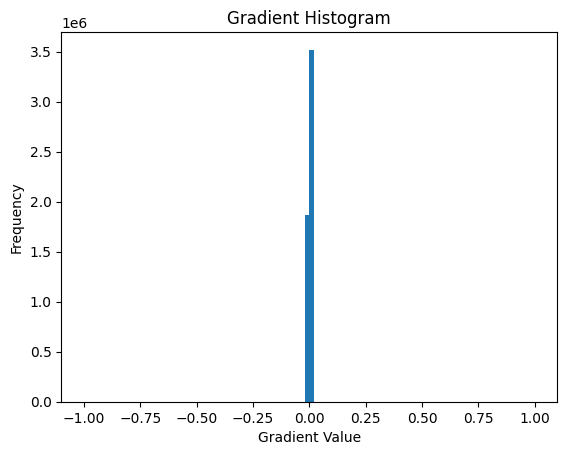

val Loss: 191.3043 Acc: 58.5455
Epoch 6/10
--------------------
train Loss: 175.7367 Acc: 65.9048


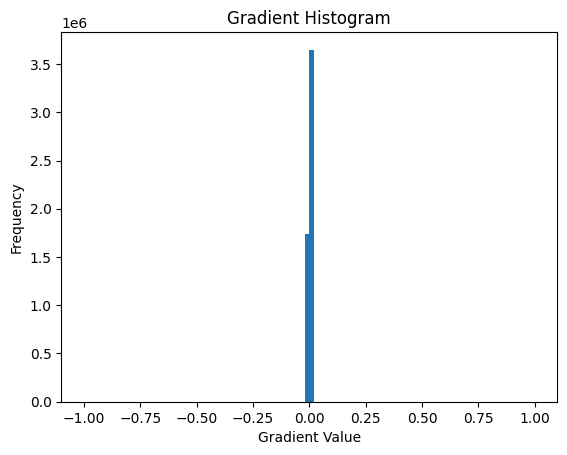

val Loss: 179.8767 Acc: 60.8182
Epoch 7/10
--------------------
train Loss: 141.2597 Acc: 78.0000


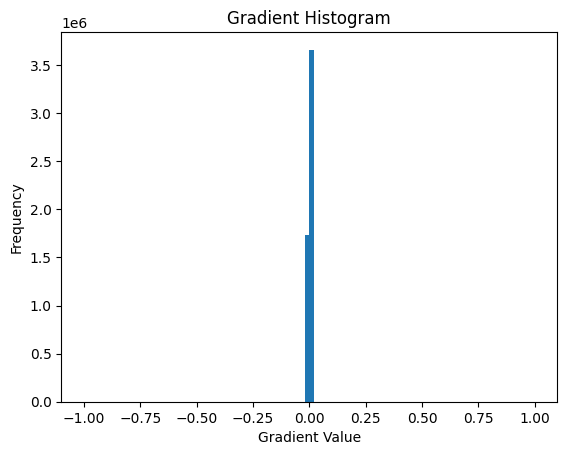

val Loss: 144.8772 Acc: 73.3636
Epoch 8/10
--------------------
train Loss: 120.6073 Acc: 84.2143


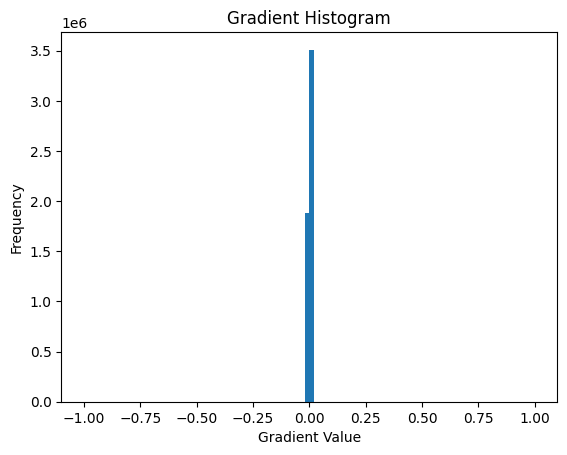

val Loss: 139.8094 Acc: 75.5455
Epoch 9/10
--------------------
train Loss: 111.9677 Acc: 87.4286


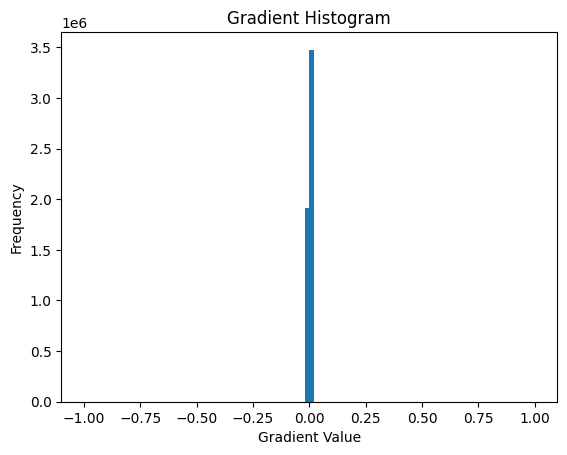

val Loss: 135.6805 Acc: 75.6364
Epoch 10/10
--------------------
train Loss: 103.5653 Acc: 90.0952


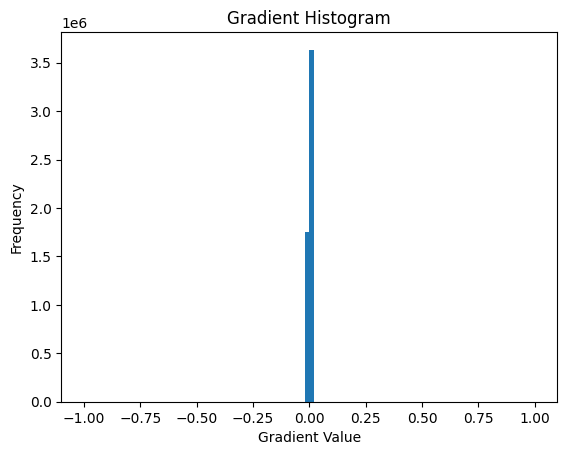

val Loss: 131.7744 Acc: 78.6364
Training complete in 4m 26s
Best val Acc: 78.636364


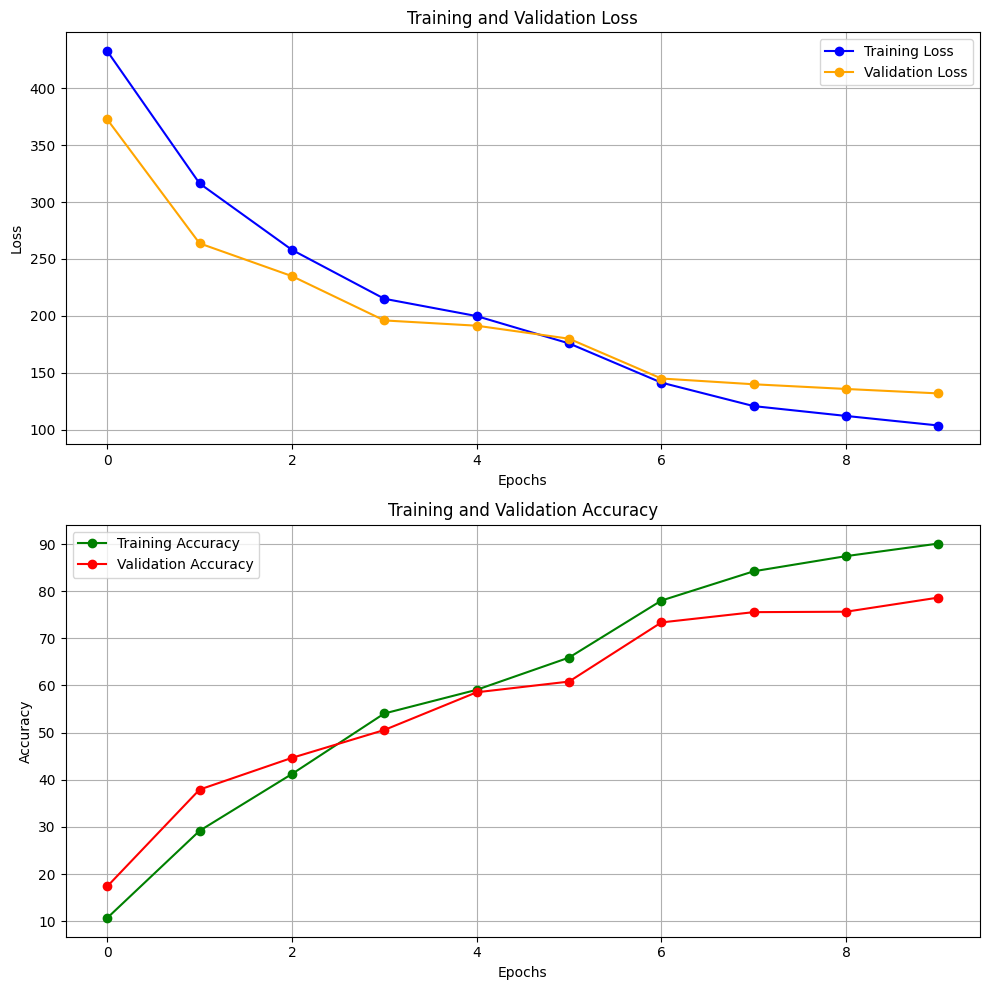

In [21]:
model = train_model(model, criterion_loss, optimizerSGD, exp_lr_scheduler, train_set, val_set, num_epochs=epochs, batch_size=bs)

ValueError: Unknown format code 'd' for object of type 'float'

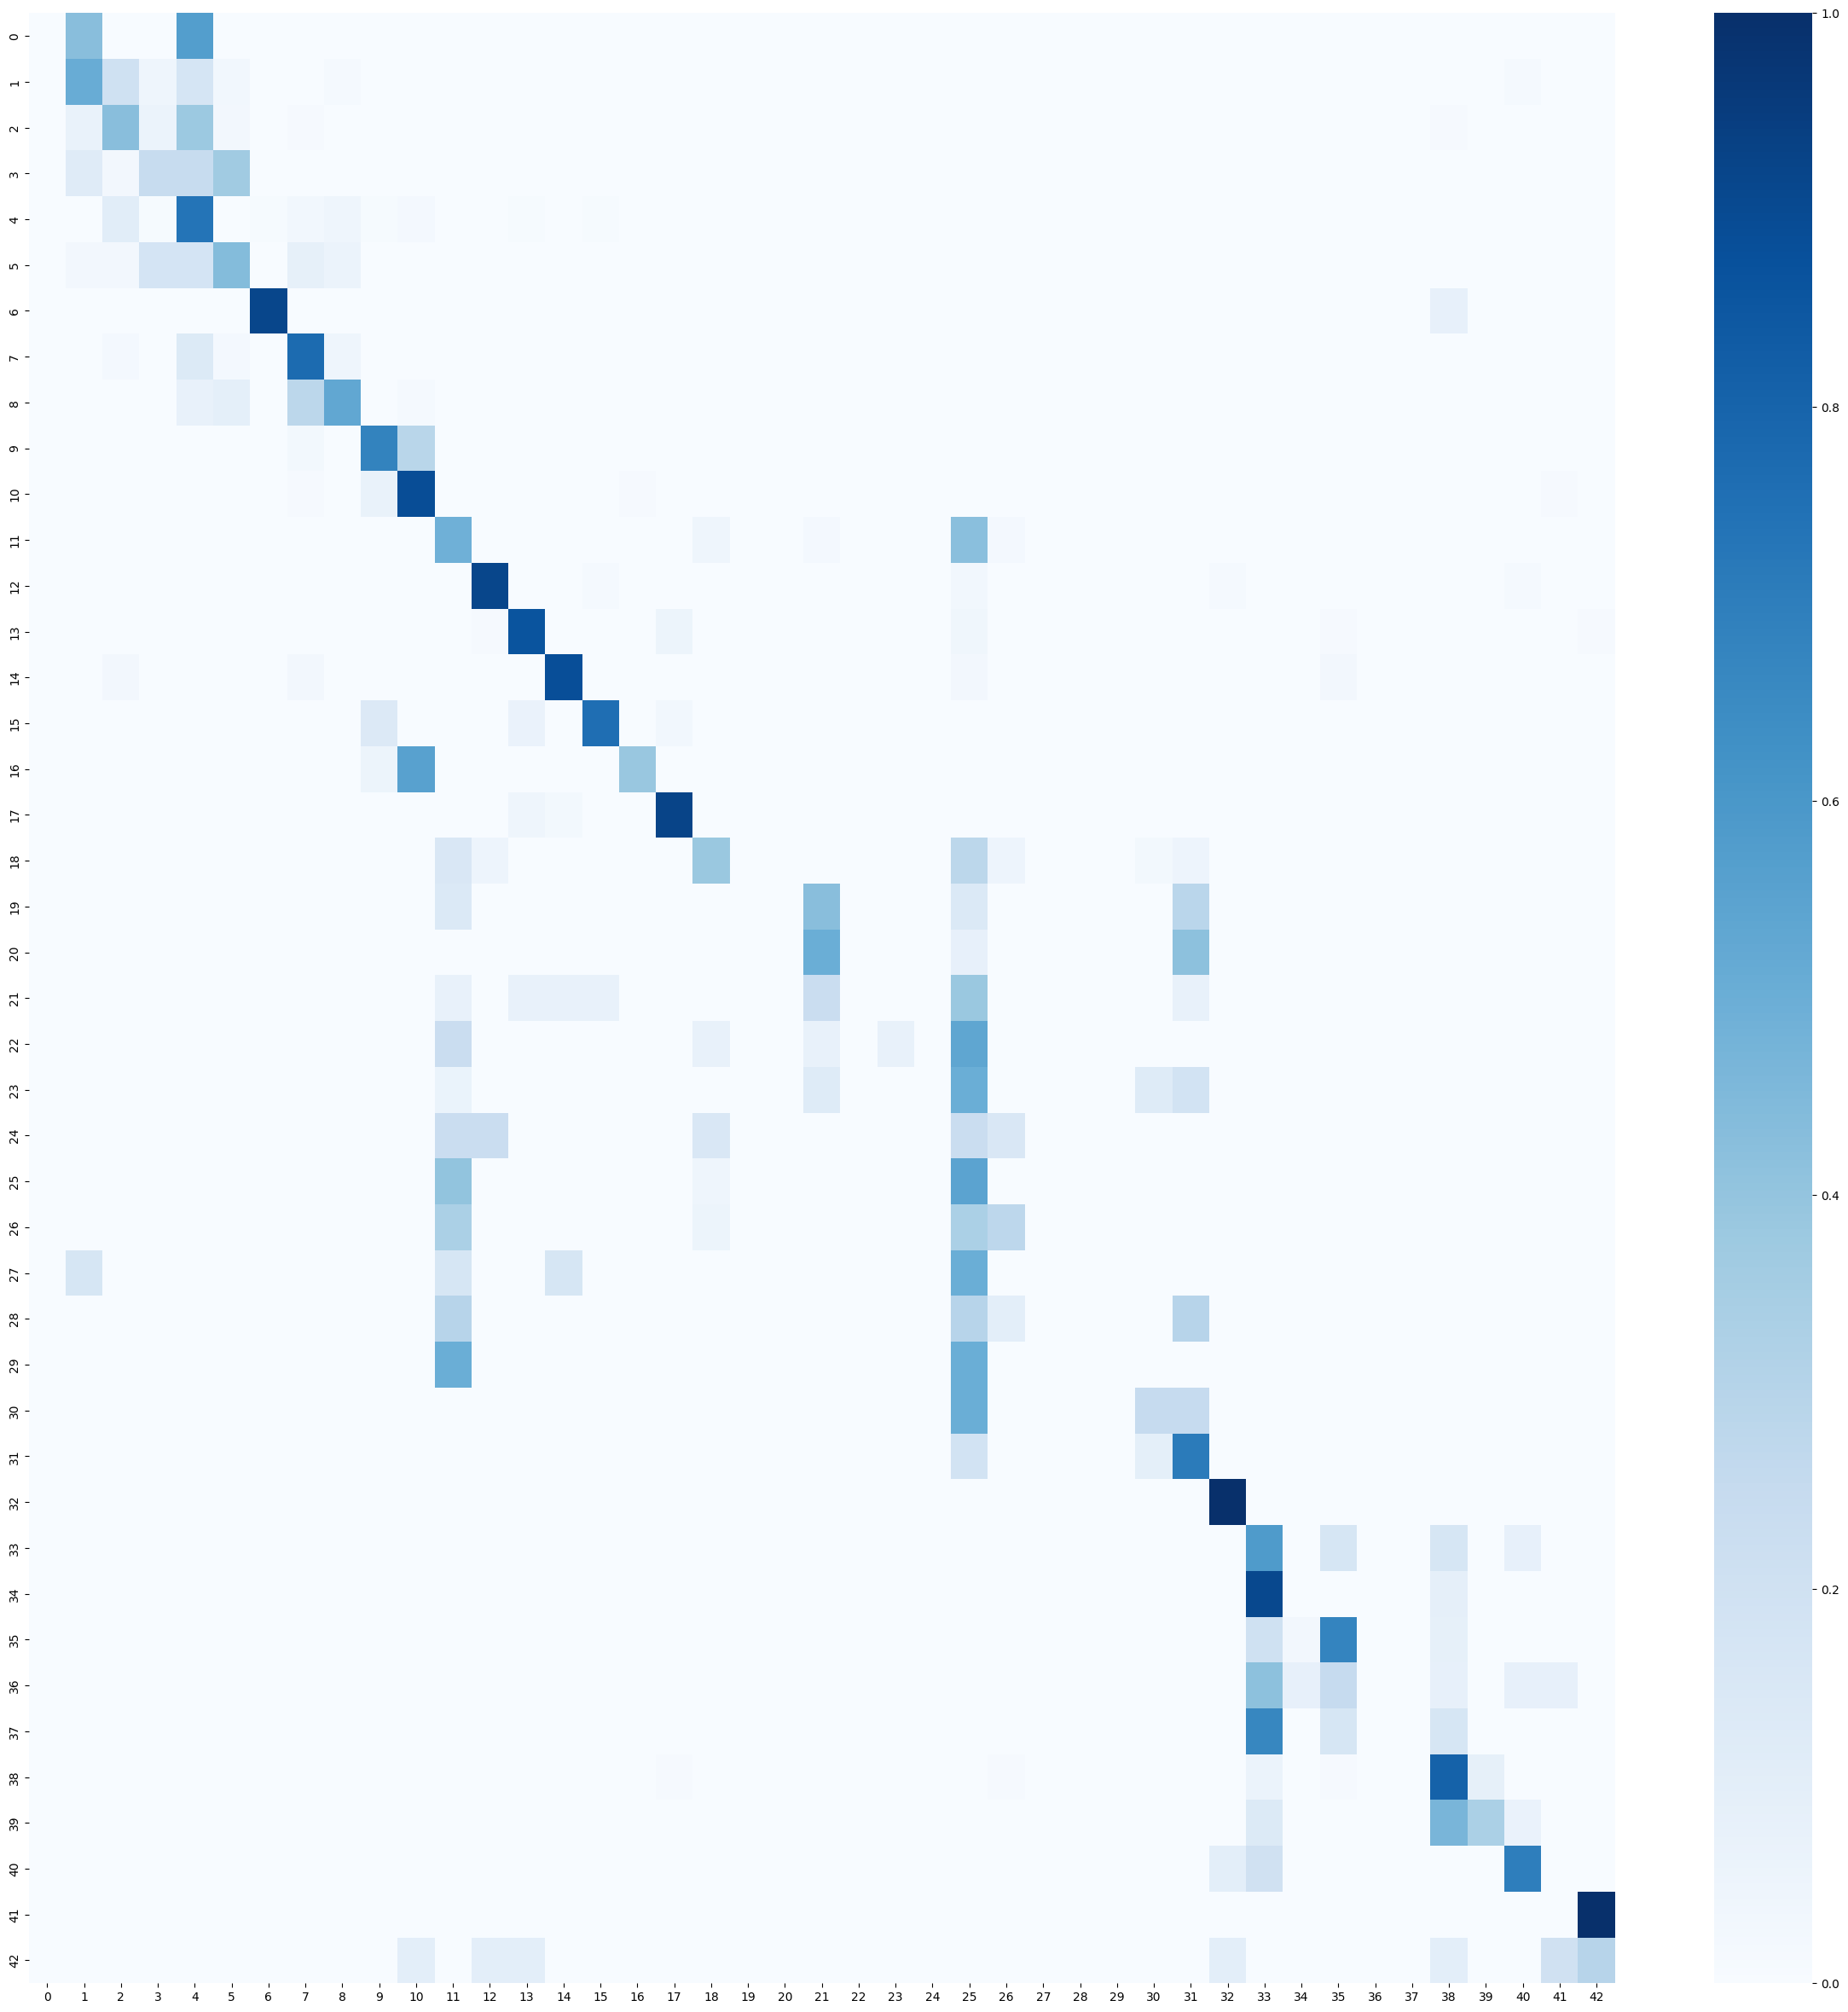

In [27]:
conf_matrix = evaluate_model(model, test_vis_set, bs)

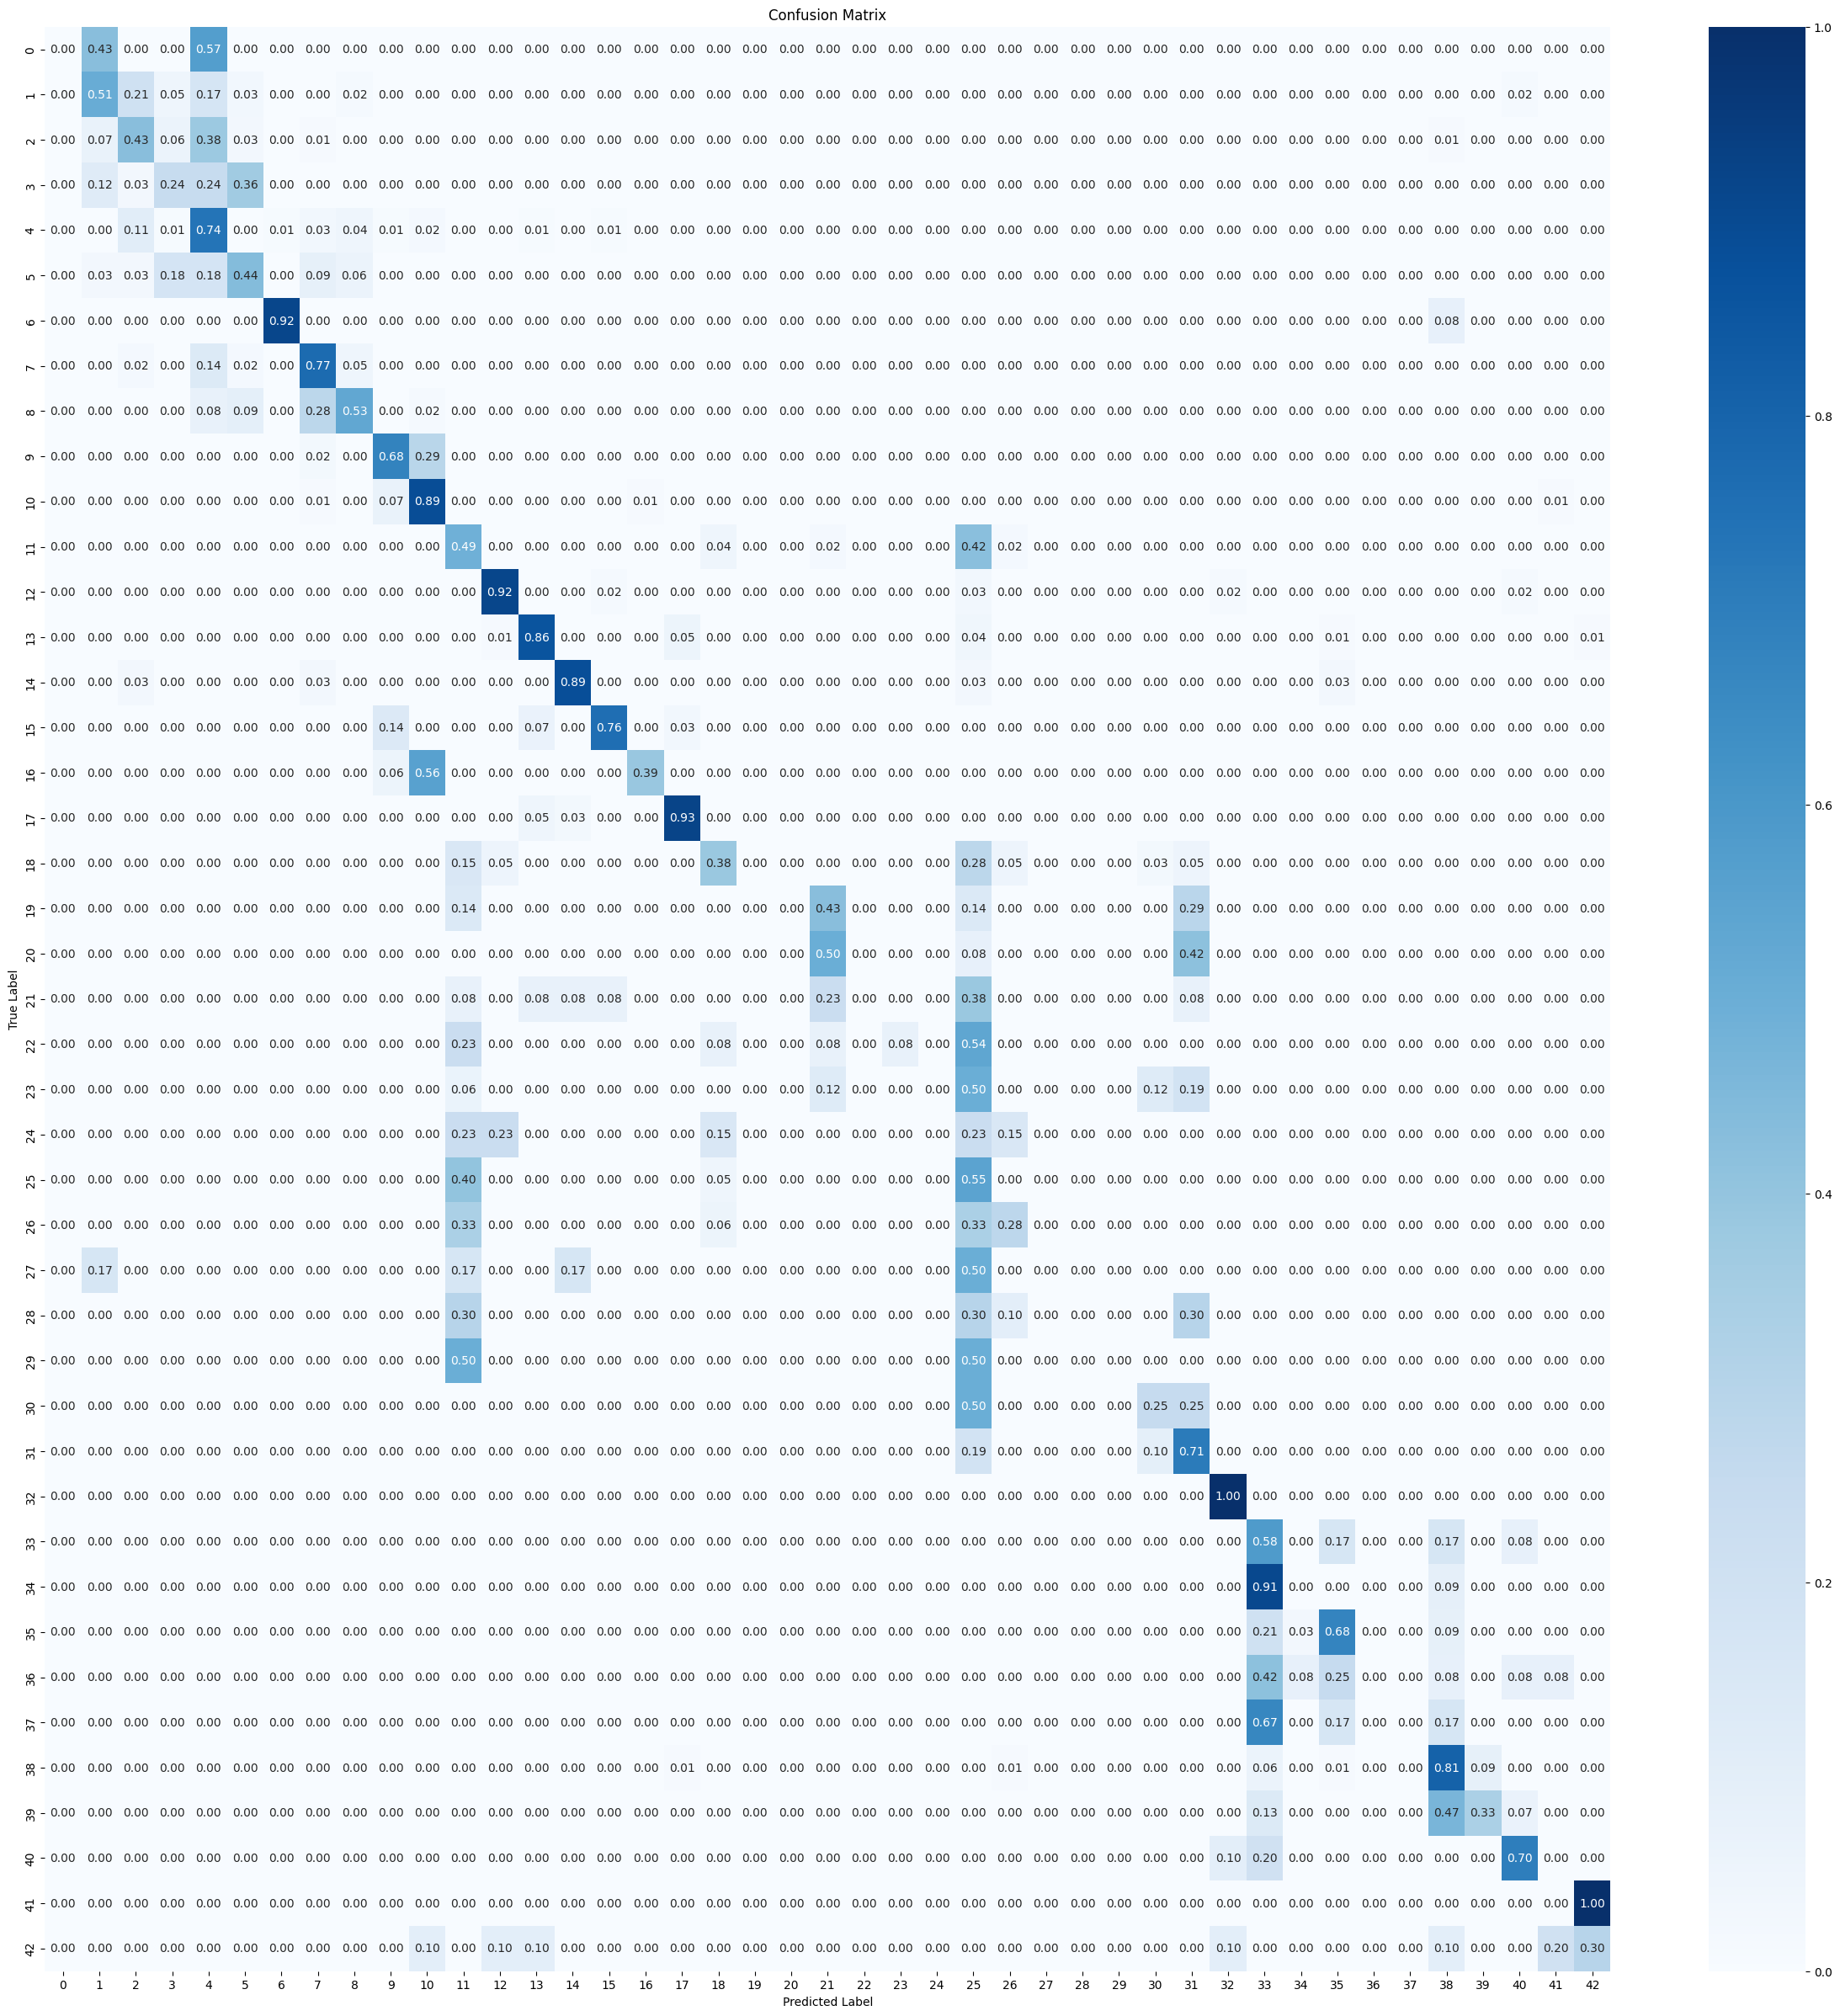

In [28]:
plt.figure(figsize=(30,30))
sns.heatmap(conf_matrix, annot=True, fmt=".2f", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()